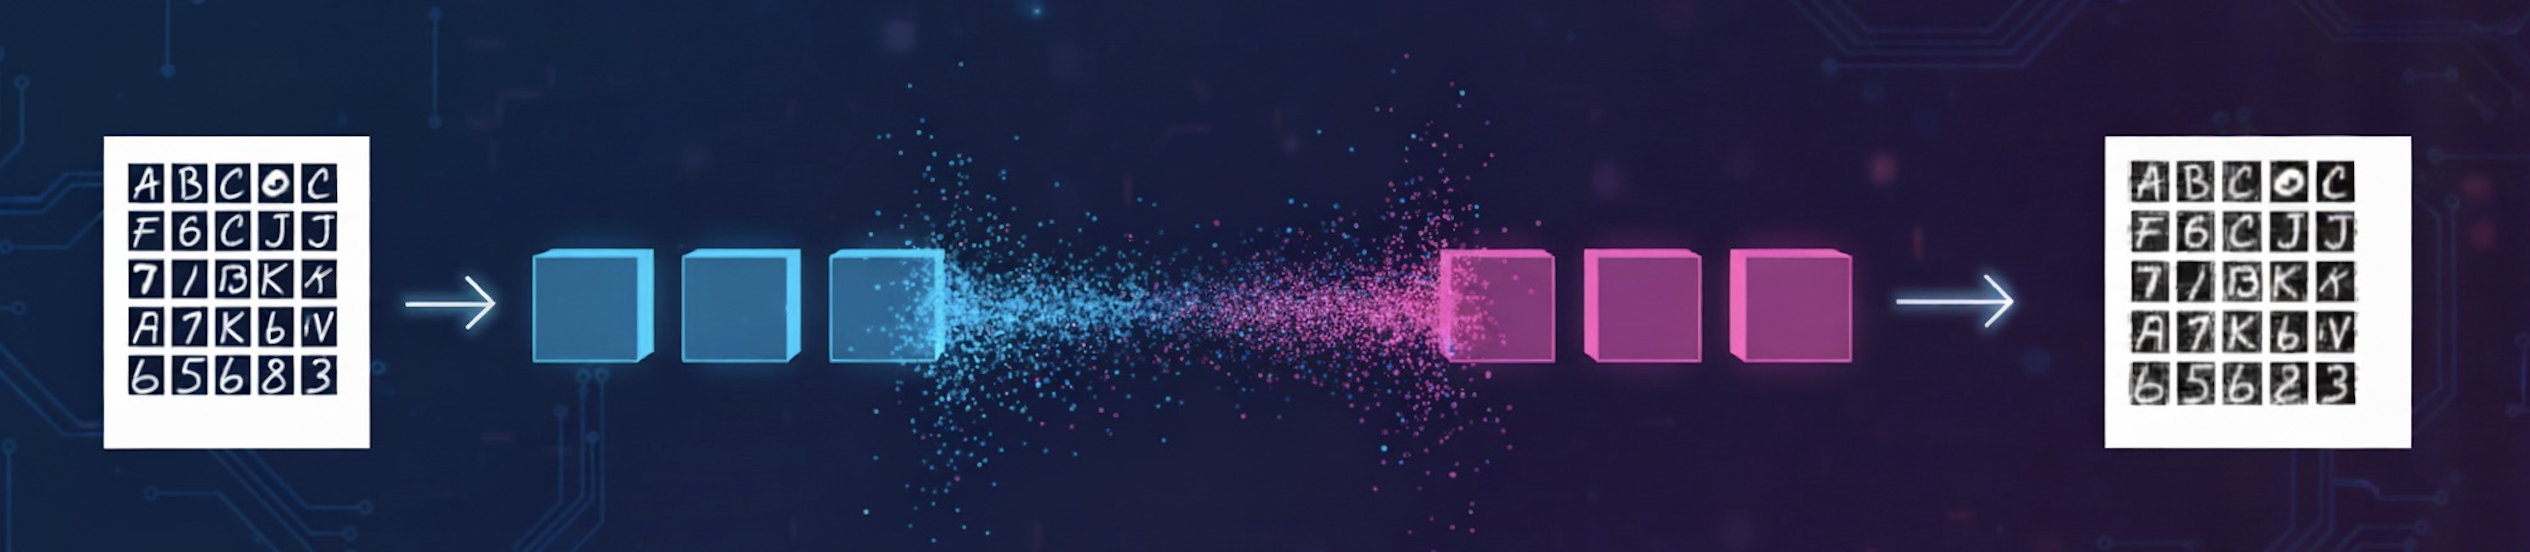

# Titkos üzenet dekódolása autoencoder segítségével

Egy konvolúciós autoencoder modellt betanítottunk az EMNIST kézzel írt karakterek adatbázisán. Az encoder rész feladata a képek tömörítése vektorokká, míg a decoder a vektorokból állítja vissza a képeket.

## Amit megkapsz:
- A betanított encoder súlyait ('encoder_weights.pth')
- egy kódolt titkos üzenetet ('secret_message.pt')
- Az EMNIST datasetet

## A feladatod:
- A megadott súlyok és az EMNIST dataset segítségével saját decodert tanítani
- Megfejteni a titkos üzenetet

A megoldást a következő formában várjuk: "Titkos_uzenet"


GPU: szükséges a feladathoz!


In [ ]:
!gdown 1Wseb4uACTt8epOYAWPnLUJ4bZLnltvs1
!gdown 1OLY_QjyDxjpWArOFK4N9REF0ZodLId0s

Downloading...
From: https://drive.google.com/uc?id=1Wseb4uACTt8epOYAWPnLUJ4bZLnltvs1
To: /content/encoder_weights.pth
100% 424k/424k [00:00<00:00, 135MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OLY_QjyDxjpWArOFK4N9REF0ZodLId0s
To: /content/secret_message.pt
100% 9.61k/9.61k [00:00<00:00, 27.1MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [ ]:
class Encoder(nn.Sequential):
    def __init__(self):
        super(Encoder, self).__init__(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )

In [ ]:
transform = transforms.Compose([
    lambda img: transforms.functional.rotate(img, -90),
    lambda img: transforms.functional.hflip(img),
    transforms.ToTensor()
])

In [ ]:
# https://docs.pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html

train_set = datasets.EMNIST(root='./data', split='byclass', train=True, download=True, transform=transform)
secret_vectors = torch.load('secret_message.pt')

# hint: !!! use a subset to keep training fast in Colab !!!


In [ ]:
# TODO: Build and train decoder

# 1. Define Decoder architecture (mirror of Encoder)
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(x)

# 2. Load encoder weights and freeze
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder().to(device)
encoder.load_state_dict(torch.load('encoder_weights.pth', map_location=device))
encoder.eval()
for param in encoder.parameters():
    param.requires_grad = False

# 3. Initialize decoder
decoder = Decoder().to(device)

# 4. Prepare data (use subset for faster training)
subset_indices = torch.randperm(len(train_set))[:50000]  # Use 50k samples
train_subset = torch.utils.data.Subset(train_set, subset_indices)
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

# 5. Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)
epochs = 10

# 6. Train decoder
print("Training decoder...")
decoder.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        # Encode with frozen encoder
        with torch.no_grad():
            encoded = encoder(data)
        
        # Decode
        decoded = decoder(encoded)
        
        # Compute loss
        loss = criterion(decoded, data)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

print("Decoder training complete!")

# 7. Decode secret message
decoder.eval()

# Convert list of tensors to a batch tensor
secret_vectors_batch = torch.cat([v.to(device) for v in secret_vectors], dim=0)

with torch.no_grad():
    decoded_images = decoder(secret_vectors_batch)

# 8. Visualize decoded images
n_images = decoded_images.shape[0]
fig, axes = plt.subplots(1, n_images, figsize=(n_images*2, 2))
for i in range(n_images):
    axes[i].imshow(decoded_images[i].cpu().squeeze(), cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 9. Map images to characters using EMNIST byclass mapping
# EMNIST byclass: 0-9 are digits, 10-35 are uppercase, 36-61 are lowercase
def idx_to_char(idx):
    if idx < 10:
        return str(idx)
    elif idx < 36:
        return chr(ord('A') + idx - 10)
    else:
        return chr(ord('a') + idx - 36)

# Find closest match for each decoded image
decoded_message = []
print("\nAnalyzing decoded images...")

for i in range(n_images):
    decoded_img = decoded_images[i].cpu()
    min_diff = float('inf')
    best_match = 0
    
    # Compare with a sample from each class
    for class_idx in range(62):  # EMNIST byclass has 62 classes
        # Get first sample from this class
        class_samples = [idx for idx, (_, label) in enumerate(train_set) if label == class_idx]
        if len(class_samples) > 0:
            sample_img, _ = train_set[class_samples[0]]
            sample_img = sample_img.to(device)
            
            # Encode and decode to get comparable representation
            with torch.no_grad():
                sample_encoded = encoder(sample_img.unsqueeze(0))
                sample_decoded = decoder(sample_encoded)
            
            # Compute difference
            diff = torch.sum((decoded_img - sample_decoded.cpu().squeeze()) ** 2).item()
            
            if diff < min_diff:
                min_diff = diff
                best_match = class_idx
    
    char = idx_to_char(best_match)
    decoded_message.append(char)
    print(f"Image {i+1}: {char} (class {best_match})")

# 10. Print final message
final_message = ''.join(decoded_message)
print(f"\n{'='*50}")
print(f"DECODED SECRET MESSAGE: {final_message}")
print(f"{'='*50}")
print(f"\nAnswer format: {final_message}")